In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
cd ../sim

/home/fernando/S1LFP/S1_netpyne/sim


## cfg

In [3]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs
import pickle
import os
import numpy as np

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 2.0*1e1 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4322, 'stim': 4322, 'loc': 4322} 
cfg.hParams = {'celsius': 34, 'v_init': -69.5}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.rootFolder = os.getcwd()

# Load cells info from previously saved using netpyne (False: load from HOC BBP files, slower)
cfg.loadcellsfromJSON = True

cfg.poptypeNumber = 61 # max 55 + 6
cfg.celltypeNumber = 213 # max 207 + 6

#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

    if mtype not in popParam:
        popParam.append(mtype)
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])
    
cfg.S1pops = popParam[0:55]
cfg.S1cells = cellParam[0:207]

#------------------------------------------------------------------------------  
cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  

## Run only selected populations (me-types)

# subPopLabels = cfg.S1pops[36:38] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14
# subPopLabels = ['L4_PC','L4_LBC','L5_TTPC1','L5_MC'] #
# subPopLabels = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
#              'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
#              'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
subPopLabels = cfg.S1pops
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells
#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  
#------------------------------------------------------------------------------  

#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 1
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype # need more test!!!
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)

                    
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False			
cfg.recordTime = False  		
cfg.recordStep = 0.1            

cfg.recordLFP = [[xz, y, xz] for xz in [210, 0] for y in [500, 1000, 1500, 2000]] 
# cfg.saveLFPPops =  cfg.recordCells 

# cfg.recordLFP = [[x, y, z] for y in [250, 1250, 1300] for x in range(185, 241, 50) for z in range(185, 241, 50)]

#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'LFP2p'
cfg.saveFolder = '../data/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False	        	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData', 'simConfig', 'netParams', 'net'] ## , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			
cfg.saveCellConns = True	

#------------------------------------------------------------------------------
# Analysis and plotting 
# ------------------------------------------------------------------------------
# cfg.analysis['plotRaster'] = {'include': cfg.allpops, 'saveFig': True, 'showFig': False, 'orderInverse': True, 'timeRange': [0,cfg.duration], 'figSize': (36,18), 'labels': 'legend', 'popRates': True, 'fontSize':12, 'lw': 1, 'markerSize':2, 'marker': '.', 'dpi': 300} 
# cfg.analysis['plot2Dnet']   = {'include': cfg.allpops, 'saveFig': True, 'showConns': False, 'figSize': (24,24), 'fontSize':16}   # Plot 2D cells xy
# cfg.analysis['plotTraces'] = {'include': cfg.recordCells, 'oneFigPer': 'cell', 'overlay': True, 'timeRange': [0,cfg.duration], 'saveFig': True, 'showFig': False, 'figSize':(12,4)}
# cfg.analysis['plot2Dfiring']={'saveFig': True, 'figSize': (24,24), 'fontSize':16}
# cfg.analysis['plotConn'] = {'includePre': cfg.allpops, 'includePost': cfg.allpops, 'feature': 'numConns', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'saveData':'../data/v5_batch0/v5_batch0_matrix_numConn.json', 'fontSize': 18}
# cfg.analysis['plotConn'] = {'includePre': ['L1_DAC_cNA','L23_MC_cAC','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1'], 'includePost': ['L1_DAC_cNA','L23_MC_cAC','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1'], 'feature': 'convergence', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'fontSize': 18}
# cfg.analysis['plot2Dnet']   = {'include': ['L5_LBC', 'VPM_sTC', 'POm_sTC_s1'], 'saveFig': True, 'showConns': True, 'figSize': (24,24), 'fontSize':16}   # Plot 2D net cells and connections
# cfg.analysis['plotShape'] = {'includePre': cfg.recordCells, 'includePost': cfg.recordCells, 'showFig': False, 'includeAxon': False, 
                            # 'showSyns': False, 'saveFig': True, 'dist': 0.55, 'cvar': 'voltage', 'figSize': (24,12), 'dpi': 600}

# cfg.analysis['plotLFP'] = {'plots': ['timeSeries'], 'figSize': (8,4), 'saveData': False, 'saveFig': True, 'showFig': False} #, 'electrodes': [10], 'maxFreq': 80 'PSD', 'spectrogram'

# cfg.analysis['plotLFP'] = {'separation': 1.0, 'plots': ['timeSeries', 'locations'], 'timeRange': [900,4900], 'electrodes': [ii for ii in range(4)], 'saveFig': True, 'showFig': False}

#------------------------------------------------------------------------------
# Network 
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 2082.0
cfg.sizeX = 420.0 # r = 210 um and hexagonal side length = 230.9 um
cfg.sizeZ = 420.0 
cfg.scaleDensity = 1.0/100.0 #270.5625 # 49.0 # Number of cells = 31346
#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = False  # decrease the transient
 
cfg.IClamp = []
cfg.IClampnumber = 0

for popName in cfg.allpops:
    cfg.IClamp.append({'pop': popName, 'sec': 'soma', 'loc': 0.5, 'start': 150, 'dur': 100, 'amp': 0.2}) #pA
    cfg.IClampnumber=cfg.IClampnumber+1


## netParams 

In [4]:

"""
netParams.py

High-level specifications for S1 network model using NetPyNE

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs
import pandas as pd

netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
netParams.scale = cfg.scale # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	


cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)


#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
## S1

for cellName in cfg.S1cells:
    layernumber = cellName[1:2]
    if layernumber == '2':
        netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 'xnormRange': [0.5-0.5/5.0, 0.5+0.5/5.0],  'znormRange': [0.5-0.5/5.0, 0.5+0.5/5.0],
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}
    else:
        netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 'xnormRange': [0.5-0.5/5.0, 0.5+0.5/5.0],  'znormRange': [0.5-0.5/5.0, 0.5+0.5/5.0],
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}  
        
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
if not cfg.loadcellsfromJSON:     ## Load cell rules using BBP template
    
    def loadTemplateName(cellMe):     
        outFolder = cfg.rootFolder+'/cell_data/'+cellMe
        try:
            f = open(outFolder+'/template.hoc', 'r')
            for line in f.readlines():
                if 'begintemplate' in line:
                    return str(line)[14:-1]     
        except:
            print('Cannot read cell template from %s' % (outFolder))
            return False

    cellnumber = 0    
    for cellName in cfg.S1cells:

        if cfg.cellNumber[cellName] < 5:
            morphoNumbers = cfg.cellNumber[cellName]
        else:
            morphoNumbers = 5

        for morphoNumber in range(morphoNumbers):
            cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
            print(cellMe,cellName)

            cellTemplateName = loadTemplateName(cellMe)

            if cellTemplateName:

                cellRule = netParams.importCellParams(label=cellMe, somaAtOrigin=True,
                    conds={'cellType': cellMe, 'cellModel': 'HH_full'},
                    fileName='cellwrapper.py',
                    cellName='loadCell',
                    cellInstance = True,
                    cellArgs={'cellName': cellMe, 'cellTemplateName': cellTemplateName})

                netParams.renameCellParamsSec(label=cellMe, oldSec='soma_0', newSec='soma')              
                for secname2 in netParams.cellParams[cellMe]['secLists'].keys():
                 if 'soma_0' in netParams.cellParams[cellMe]['secLists'][secname2]:
                   print(cellMe,secname2,netParams.cellParams[cellMe]['secLists'][secname2][0])
                   netParams.cellParams[cellMe]['secLists'][secname2][0] = 'soma'    

## S1 cell property rules
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    cellFraction = 1.0/morphoNumbers
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        if cfg.loadcellsfromJSON:
            # Load cell rules previously saved using netpyne format
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.json')        
#             netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/L5_TTPC1_cADpyr232_5/L5_TTPC1_cADpyr232_5_cellParams.json')       
        else:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['conds']['cellType'] = cellName
            cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
            cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']      
            cellRule['secLists']['spiny'] = {}
            cellRule['secLists']['spinyEE'] = {}
            nonSpiny = ['axon_0', 'axon_1']
            cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
            nonSpinyEE = ['axon_0', 'axon_1', 'soma']
            cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params  

            
# Syns
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 

#------------------------------------------------------------------------------    
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for j in range(cfg.IClampnumber):
        key ='IClamp'
        params = getattr(cfg, key, None)
        key ='IClamp'+str(j+1)
        params = params[j]
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

## init

In [5]:
%matplotlib inline

In [6]:
"""
init.py
Starting script to run NetPyNE-basedS1 model.
Usage:
    python init.py # Run simulation, optionally plot a raster
MPI usage:
    mpiexec -n 4 nrniv -python -mpi init.py
Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import sim

# cfg, netParams = sim.readCmdLineArgs()
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations


Start time:  2022-07-12 18:17:23.360286

Creating network of 207 cell populations on 1 hosts...
  Number of cells on node 0: 476 
  Done; cell creation time = 9.06 s.


[compartCell_L1_DAC_bNA_HH_full_0,
 compartCell_L1_DAC_cNA_HH_full_1,
 compartCell_L1_DLAC_cNA_HH_full_2,
 compartCell_L1_HAC_bNA_HH_full_3,
 compartCell_L1_HAC_cIR_HH_full_4,
 compartCell_L1_HAC_cNA_HH_full_5,
 compartCell_L1_NGC-DA_bNA_HH_full_6,
 compartCell_L1_NGC-DA_cAC_HH_full_7,
 compartCell_L1_NGC-DA_cNA_HH_full_8,
 compartCell_L1_NGC-DA_cST_HH_full_9,
 compartCell_L1_NGC-SA_cNA_HH_full_10,
 compartCell_L1_SLAC_bNA_HH_full_11,
 compartCell_L1_SLAC_cAC_HH_full_12,
 compartCell_L1_SLAC_cNA_HH_full_13,
 compartCell_L23_BP_bAC_HH_full_14,
 compartCell_L23_BP_bIR_HH_full_15,
 compartCell_L23_BP_bNA_HH_full_16,
 compartCell_L23_BP_cAC_HH_full_17,
 compartCell_L23_BP_cNA_HH_full_18,
 compartCell_L23_BP_dST_HH_full_19,
 compartCell_L23_BTC_bAC_HH_full_20,
 compartCell_L23_BTC_bIR_HH_full_21,
 compartCell_L23_BTC_bNA_HH_full_22,
 compartCell_L23_BTC_cAC_HH_full_23,
 compartCell_L23_BTC_cNA_HH_full_24,
 compartCell_L23_ChC_cAC_HH_full_25,
 compartCell_L23_ChC_cNA_HH_full_26,
 compartCell

In [7]:
sim.net.cells[-1].secs['soma'].items()

dict_items([('mechs', {CaDynamics_E2: {decay: 873.498863, depth: 0.1, gamma: 0.000996, minCai: 0.0001}, Ca_HVA: {gCa_HVAbar: 0.000459}, Ca_LVAst: {gCa_LVAstbar: 0.005592}, Ih: {gIhbar: 8e-05}, NaTs2_t: {gNaTs2_tbar: 0.976885}, SK_E2: {gSK_E2bar: 0.003869}, SKv3_1: {gSKv3_1bar: 0.072929}, pas: {e: -75.0, g: 3e-05}}), ('ions', {ca: {e: 132.4579341637009, i: 5e-05, o: 2.0}, k: {e: -85.0, i: 54.4, o: 2.5}, na: {e: 50.0, i: 10.0, o: 140.0}}), ('geom', {L: 15.649399824049413, Ra: 100.0, cm: 1.0, diam: 10.201226195103343, nseg: 1, pt3d: [[0.423519566655159, -7.81322968006134, 0.0, 3.855562686920166], [0.38116760551929474, -7.031906723976135, 0.0, 6.79742431640625], [0.3388156592845917, -6.25058376789093, 0.0, 8.509574890136719], [0.2964636981487274, -5.469260811805725, 0.0, 9.466983795166016], [0.25411173701286316, -4.68793785572052, 0.0, 10.353529930114746], [0.2117597758769989, -3.906614661216736, 0.0, 11.16904067993164], [0.16940784454345703, -3.12529194355011, 0.0, 11.92708969116211], [0.

In [8]:
sim.net.cells[0].tags

{'cellType': 'L1_DAC_bNA',
 'cellModel': 'HH_full',
 'pop': 'L1_DAC_bNA',
 'xnorm': 0.5079472158185248,
 'ynorm': 0.06382379434867208,
 'znorm': 0.41884988005555746,
 'x': 213.3378306437804,
 'y': 132.88113983393526,
 'z': 175.91694962333412,
 'fraction': 0.0}

In [10]:
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
# sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc

Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Recording 207 traces of 1 types on node 0

Gathering data...
  Done; gather time = 9.84 s.

Analyzing...
  Cells: 476
  Connections: 0 (0.00 per cell)
  Done; plotting time = 0.00 s


In [11]:
sim.net.cells[-1].tags

{'cellType': 'L6_UTPC_cAD',
 'cellModel': 'HH_full',
 'pop': 'L6_UTPC_cAD',
 'xnorm': 0.43067597125468954,
 'ynorm': 0.8796493768934976,
 'znorm': 0.5492323267580391,
 'x': 180.8839079269696,
 'y': 1831.4300026922622,
 'z': 230.67757723837644,
 'fraction': 0.9444444444444444}

In [ ]:
# sim.net.cells[-1].conns

Plotting 3D cell shape ...
  There was an exception in plotShape(): 
    argument of type 'bool' is not iterable 
    (<class 'TypeError'>, TypeError("argument of type 'bool' is not iterable"), <traceback object at 0x7f7321b52500>)


-1

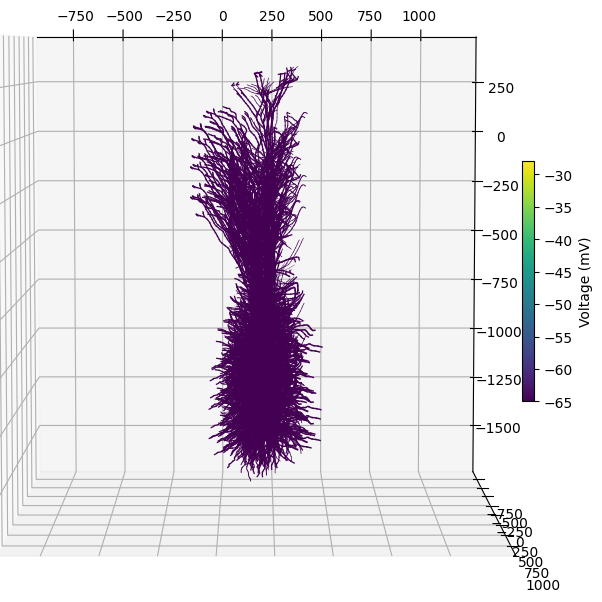

In [12]:
sim.analysis.plotShape(includePre=['L5_TTPC1_cAD'], includePost=['L5_TTPC1_cAD'], includeAxon=False, showSyns=True, showElectrodes=True,
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-65, -28], showFig=1, synSize=2)

In [ ]:
sim.analysis.plotShape(includePre=['L5_TTPC1_cAD'], includePost=['L5_TTPC1_cAD'], includeAxon=False, showSyns=True, showElectrodes=True,
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-65, -28], showFig=1, synSize=2)

Plotting LFP electrode locations...
Plotting 3D cell shape ...


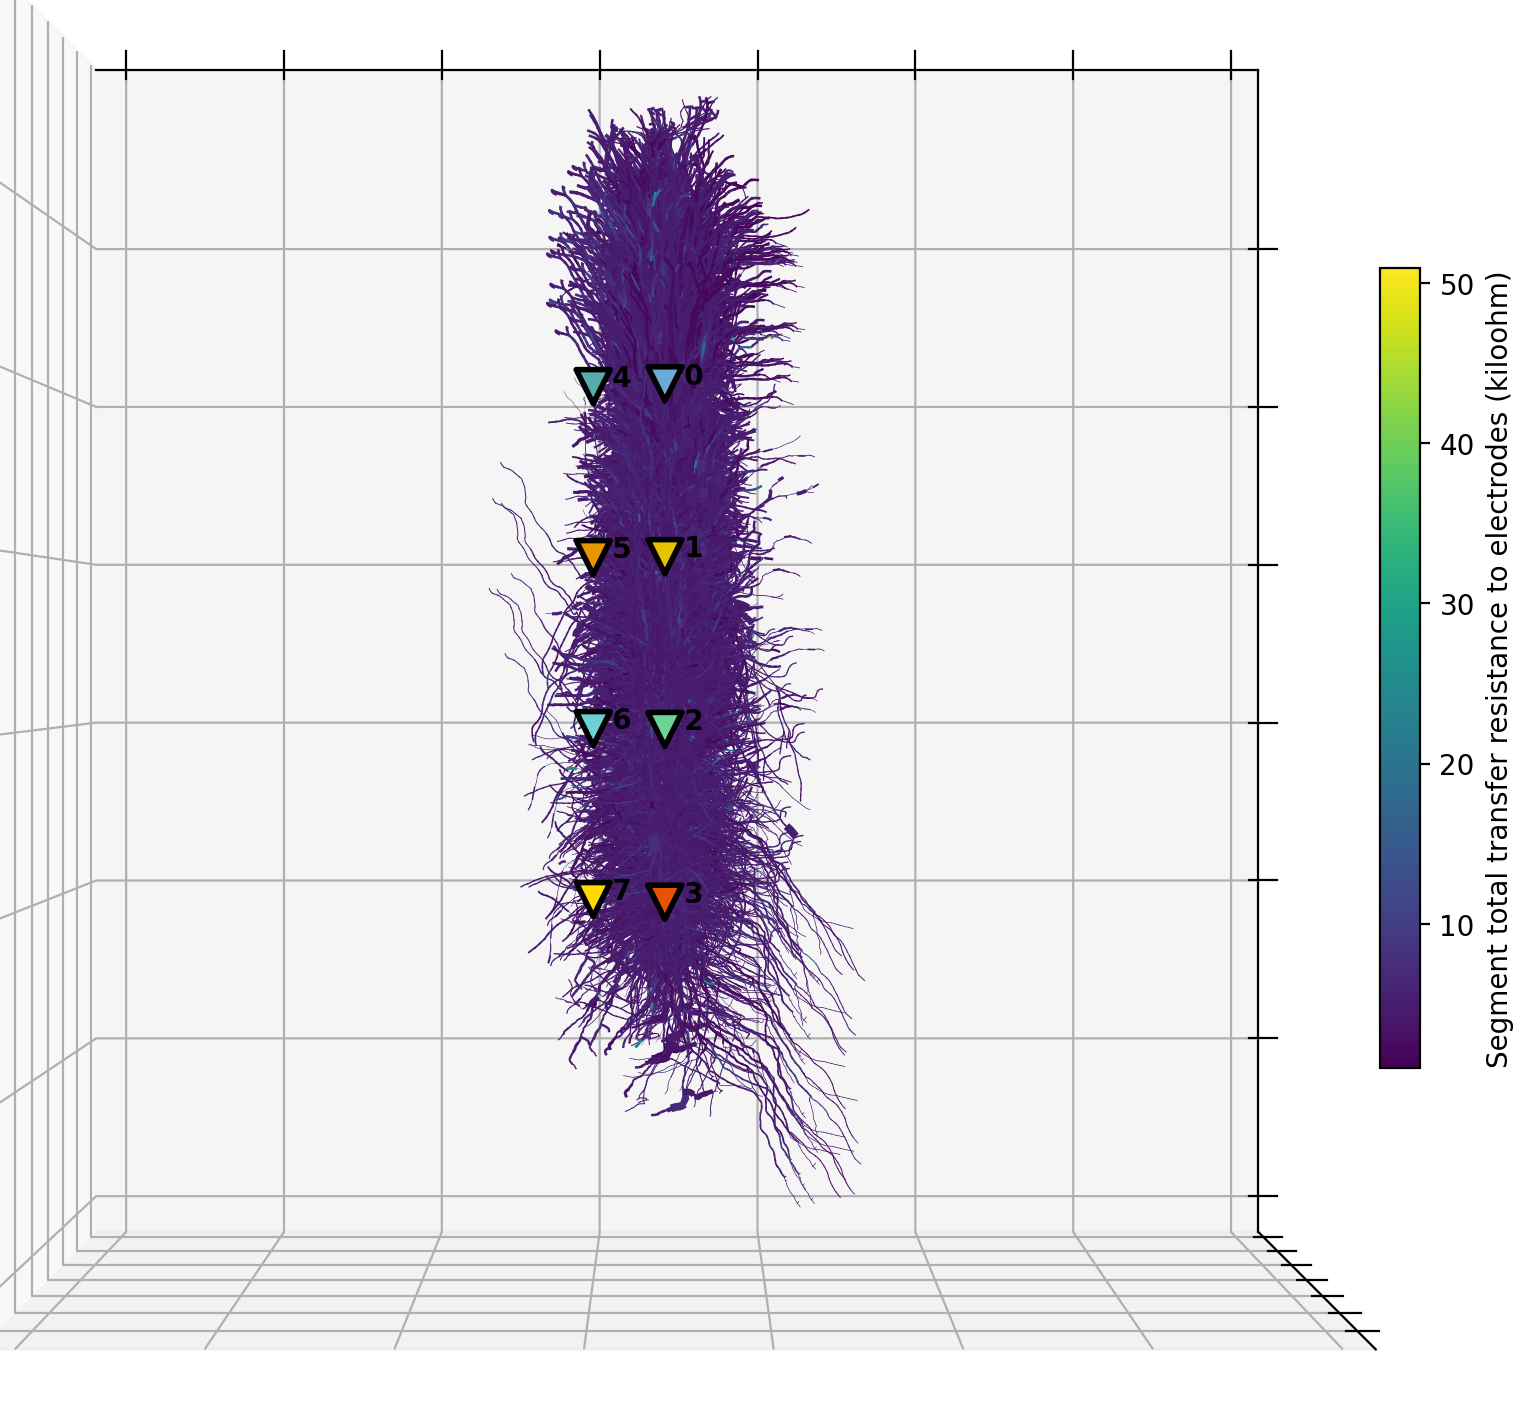

In [13]:
sim.analysis.plotLFP(**{'plots': ['locations'], 'electrodes': [0,1,2,3,4,5,6,7]})